# Intro

The OECD database is composed of hundreds (if not thousands) of tables that focus on specific economic and social variables. These variables are attirbutable to individual countries, and are generally recorded over time, making them a time series. 

For the purposes of this analysis, we are only interested in the latest year's data point, which would reflect the most recent characterization of each country's social and economic situation. 

However, given that we have years of data for each country, there is also the potential to use the change in the variable as a feature of our modeling. For example, rapid improvement in immunization coverage for a country would imply effective health education and could represent a more accurate picture of how the country is better educating the public about a new pandemic versus a country with a higher, but stagnant, immunization record. 

For now, we are combining the various OECD tables on the 'country' key so that we can merge it with COVID data.

Data transformation to follow.

# Loading and Cleaning Data

Here we load and clean csv data taken from the OECD database. This includes datasets on the following topics:
- Education
- Government Debt
- Immunization
- Demographics / Population
- Tourism
- Wealth Distribution
- Life Expectancy

For each dataset, there are multiple columns we are not interested in. Furthermore, for the columns we do want, there are different enteries for that variable, so we need to filter on what we are looking for. 

The tables and column names are not standardized, so each csv file will have to be cleaned and prepared individually. 

### Load Packages

In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import ssl
import json
import requests

ssl._create_default_https_context = ssl._create_unverified_context

## OECD


### Education

We hypothesize that a country's education should play a key role in the success rate of the country's approach to COVID. Specifically, a more highly educated country should, in theory, have a more effective approach to dealing with the virus, and should have a populace that better understands public health terminiology, what viruses are, and would be more willing to take the pandemic seriously. 

So we will focus on the share of population of countries that have a tertiary education level. This is defined on wikipedia as:

*Tertiary education, also referred to as third-level, third-stage or post-secondary education, is the educational level following the completion of secondary education. The World Bank, for example, defines tertiary education as including universities as well as trade schools and colleges.*

In [2]:
url_edu = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Education_Statistics.csv'
dfraw_edu = pd.read_csv(url_edu)


In [3]:
columns_to_use = ['COUNTRY', 'Country', 'Gender', 'ISCED 2011 A education level', 'Reference Period', 'Measure', 'Value']

# Only select the columns we want to use
df_edu = dfraw_edu[columns_to_use]

# filter some of the columns to include the variables we want to see
df_edu = df_edu[df_edu['ISCED 2011 A education level'] == "Tertiary education"]
df_edu = df_edu[df_edu['Gender'] == "Total"]
df_edu = df_edu[df_edu['Measure'] == "Value"]

# Choose the latest datapoint for each country
df_edu = df_edu.sort_values('Reference Period').groupby('Country').tail(1)

# This final dataframe contains the share of each country's population that has a tertiary education. 
df_edu.head()


,COUNTRY,Country,Gender,ISCED 2011 A education level,Reference Period,Measure,Value
3244,CHN,China (People's Republic of),Total,Tertiary education,2010.0,Value,9.681174
3302,IND,India,Total,Tertiary education,2011.0,Value,10.595189
2846,SAU,Saudi Arabia,Total,Tertiary education,2016.0,Value,23.623922
2772,CHL,Chile,Total,Tertiary education,2017.0,Value,25.168179
2757,RUS,Russia,Total,Tertiary education,2017.0,Value,56.700150


In [4]:
# But lets reduce this table down to what we'll be combining together later.
# A simple country-variable table.

df_edu = df_edu[['COUNTRY', 'Country', 'Value']]
df_edu.columns = ['ISO', 'Country', 'Tertiary_Education_Pct']
df_edu.head()

,ISO,Country,Tertiary_Education_Pct
3244,CHN,China (People's Republic of),9.681174
3302,IND,India,10.595189
2846,SAU,Saudi Arabia,23.623922
2772,CHL,Chile,25.168179
2757,RUS,Russia,56.700150


### Debt

The Debt dataset from the OECD has various government-level debt statistics. Our focus here will be on the total debt-to-GDP ratio, as it helps us look at a normalized measure, rather than needing to adjust absolute debt levels across different sized countries.

Our hypothesis is a little mixed. On the surface, one would expect that a heavily indebted country is not wealthy and might have to skimp on health care spending at a time of a pandemic. Or conversely, wouldn't have room to borrow more. However, anecdotally, Japan is one of the most indebted countries in the World, but is highly developed, has a great health care system, and can easily increase its debt levels. This might be a difficult variable to gain insights on.

In [5]:
# Load the Debt Data
url_debt = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Government_Debt.csv'
dfraw_debt = pd.read_csv(url_debt)

In [6]:
# Choose the latest data point for each country
df_debt = dfraw_debt.sort_values('Time period').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_debt = df_debt[['COU', 'Country', 'Value']]
df_debt.columns = ['ISO', 'Country', 'Debt_to_GDP']

# Check to make sure it looks ok
df_debt.head()

,ISO,Country,Debt_to_GDP
208,JPN,Japan,183.530
278,NZL,New Zealand,30.450
264,NLD,Netherlands,51.845
320,PRT,Portugal,87.962
27,AUT,Austria,65.754


### Immunization

OECD also has a slew of health care data. It is not a health care organization however, so we don't want to rely too heavily on medical statistics from this source, however, they do have useful macro level information that is insightful. 

One of these variables is the percentage of individuals over 65 that are immunized for the flu. Unfortunately this isn't a statistic they have for the full population, but it is still a good proxy for how open a country is to public health initiatives, and how seriously they take flu-like diseases. 

Our hypothesis would be that the higher the level of immunization, the more successful a country is at combatting COVID.


In [7]:
# Load Immunization Data
url_imm = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Immunization_Statistics.csv'
dfraw_imm = pd.read_csv(url_imm)


In [8]:
# Choose the latest data point for each country
df_imm = dfraw_imm.sort_values('Year').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_imm = df_imm[['COU', 'Country', 'Value']]
df_imm.columns = ['ISO', 'Country', 'Pct_65_Immunized_Flu']

# Check to make sure it looks ok
df_imm.head()

,ISO,Country,Pct_65_Immunized_Flu
6,AUS,Australia,74.6
351,CHE,Switzerland,46.0
8,AUT,Austria,20.3
271,POL,Poland,9.7
224,MEX,Mexico,82.3


### Population / Demographics

OECD offers a slew of population and demographic data for global countries. Our variable of interest is regarding age demographics of countries. Specifically we will look at the Old Age Dependency Ratio. This is the ratio of a country's old-age population (>65 years) to the rest of the population. Our hypothesis is there is a positive correlation between COVID success and this ratio


In [9]:
# Load the Demographics Data
url_pop = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Population_Statistics.csv'
dfraw_pop = pd.read_csv(url_pop)

In [10]:
# Create an old age ratio dataframe
df_oldage = dfraw_pop[dfraw_pop['AGE'] == "65_OVER_SHARE"]
df_oldage = df_oldage[df_oldage['Sex'] == "Total"]

# Choose the latest data point for each country
df_oldage = df_oldage.sort_values('Time').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_oldage = df_oldage[['LOCATION', 'Country', 'Value']]
df_oldage.columns = ['ISO', 'Country', 'Old_Age_Ratio']

# Check to make sure it looks ok
df_oldage.head()

,ISO,Country,Old_Age_Ratio
58757,EU28,European Union (28 countries),19.849
58715,G20,G20,11.037
58673,WLD,World,8.921
57623,TUR,Turkey,8.649
58589,SVN,Slovenia,19.670


### Tourism

In [11]:
url_tour = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Tourism_Statistics.csv'
dfraw_tour = pd.read_csv(url_tour)


In [12]:
# We'll create two separate dataframes from the tourism table
# Tourism as % of GDP (Do a lot of people come to the country)
# and Tourism as % of Total Employment (do a lot of people interact with foreigners)

# Create Tourism as % of GDP dataframe
df_tour_gdp = dfraw_tour[dfraw_tour['KEY_IND_PC'] == "KEYIND_TOURGDPPC"]

# Choose the latest data point for each country
df_tour_gdp = df_tour_gdp.sort_values('Year').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_tour_gdp = df_tour_gdp[['COUNTRY', 'Country', 'Value']]
df_tour_gdp.columns = ['ISO', 'Country', 'Tourism_Pct_GDP']

# Check to make sure it looks ok
df_tour_gdp.head()



,ISO,Country,Tourism_Pct_GDP
564,MLT,Malta,6.129
119,IND,India,3.759
108,EGY,Egypt,4.258
115,EST,Estonia,5.428
66,POL,Poland,1.175


In [13]:
# Create Toursim employment as % of Total
df_tour_emp = dfraw_tour[dfraw_tour['KEY_IND_PC'] == "KEYIND_TOUREMPDIRECTPC"]

# Choose the latest data point for each country
df_tour_emp = df_tour_emp.sort_values('Year').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_tour_emp = df_tour_emp[['COUNTRY', 'Country', 'Value']]
df_tour_emp.columns = ['ISO', 'Country', 'Tourism_Pct_Employment']

# Check to make sure it looks ok
df_tour_emp.head()

,ISO,Country,Tourism_Pct_Employment
387,ARG,Argentina,10.17
460,IND,India,5.31
465,IDN,Indonesia,8.37
577,PER,Peru,3.82
282,ITA,Italy,8.30


### Wealth Distribution

In [14]:
url_wealth = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Wealth_Distribution_Statistics.csv'
dfraw_wealth = pd.read_csv(url_wealth)

In [15]:
# Create two dataframes from the wealth distirbution table. The focus is on
# inequality is the focus of the data.
# Share of top 10% wealth (how rich are the super-rich)
# Share of bottom 60% of wealth (how poor is the bottom half)
dfraw_wealth.head()

# First, create the top 10pct dataframe
df_top_10pct_share = dfraw_wealth[dfraw_wealth['Variable'] == 'Share of top 10% of wealth']

# Choose the latest data point for each country
df_top_10pct_share = df_top_10pct_share.sort_values('Time').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_top_10pct_share = df_top_10pct_share[['COUNTRY', 'Country', 'Value']]
df_top_10pct_share.columns = ['ISO', 'Country', 'Top_10pct_Share']

# Check to make sure it looks ok
df_top_10pct_share.head()


,ISO,Country,Top_10pct_Share
268,ESP,Spain,45.577541
752,PRT,Portugal,52.127502
487,IRL,Ireland,53.792400
325,FIN,Finland,45.231823
288,EST,Estonia,55.713390


In [16]:
# Create the bottom 60% dataframe

df_bottom_60pct_share = dfraw_wealth[dfraw_wealth['Variable'] == 'Share of bottom 60% of wealth']

# Choose the latest data point for each country
df_bottom_60pct_share = df_bottom_60pct_share.sort_values('Time').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_bottom_60pct_share = df_bottom_60pct_share[['COUNTRY', 'Country', 'Value']]
df_bottom_60pct_share.columns = ['ISO', 'Country', 'Bottom_60pct_Share']

# Check to make sure it looks ok
df_bottom_60pct_share.head()

,ISO,Country,Bottom_60pct_Share
252,ESP,Spain,18.664709
280,EST,Estonia,12.786300
736,PRT,Portugal,12.422934
479,IRL,Ireland,7.184053
309,FIN,Finland,13.552249


### Life Expectancy


In [17]:
url_life_exp = 'https://raw.githubusercontent.com/pvai-umich/SIADS591/master/Data/OECD_Life_Expectancy.csv'
dfraw_life_exp = pd.read_csv(url_life_exp)

In [18]:
# There's only one variable here, so we just need to get the last available date
# and then choose the columns we want 

# Choose the latest data point for each country
df_life_exp = dfraw_life_exp.sort_values('Year').groupby('Country').tail(1)

# Choose the columns we want and rename them.
df_life_exp = df_life_exp[['COU', 'Country', 'Value']]
df_life_exp.columns = ['ISO', 'Country', 'Life_Expectancy']

# Check to make sure it looks ok
df_life_exp.head()

,ISO,Country,Life_Expectancy
133,JPN,Japan,84.2
368,LVA,Latvia,74.9
71,FRA,France,82.8
377,CRI,Costa Rica,80.4
386,LTU,Lithuania,75.8


## COVID-19

All attempts to load json via web is throwing an SSL error. We will load locally.

-Method 1
-Request fails unless we provide a user-agent
api_response = requests.get('https://thevirustracker.com/timeline/map-data.json', headers={"User-Agent": "Chrome"})
covid_stats = api_response.json()

-Method 2
response = urlopen('https://thevirustracker.com/timeline/map-data.json')
json_data = response.read().decode('utf-8', 'replace')
df = json.loads(json_data)

### Covid-19 Daily Stats by Country

In [19]:
#Importing COVID19 Global Data
cf = 'covid_full.json'
with open(cf, 'r') as f:
    doc = json.load(f)

In [20]:
#converting to pandas data frame
covid_daily_stats=pd.DataFrame(doc)

#changing the types of the columns
covid_daily_stats['cases']=covid_daily_stats['cases'].astype('int')
covid_daily_stats['deaths']=covid_daily_stats['deaths'].astype('int')


#renaming columns for future merge
covid_daily_stats.rename(columns={'countrycode':'Alpha-2 code','date':'Date','cases':'Cases','deaths':'Deaths','recovered':'Recovered'}, inplace=True)

covid_daily_stats.sample(10)

,Alpha-2 code,Date,Cases,Deaths,Recovered
10373,MD,5/27/20,7537,274,2953
12366,NP,3/28/20,5,0,1
3857,CV,4/28/20,114,1,0
13363,PT,4/19/20,20206,714,5
12823,PG,5/30/20,8,0,0
33803,DZ,8/31/20,44494,1510,12094
19360,ZW,6/15/20,387,4,0
17828,SK,6/07/20,1528,28,7
8913,KR,4/22/20,10694,238,3166
22507,SD,7/03/20,9663,604,0


In [21]:
covid_daily_stats.dtypes

Alpha-2 code    object
Date            object
Cases            int64
Deaths           int64
Recovered       object
dtype: object

### Covid-19 Global Stats

In [22]:
#Importing COVID19 Global Data
gs= 'global_stats.json'
with open(gs, 'r') as g:
    doc1 = json.load(g)
covid_global_stats=pd.DataFrame(doc1).transpose()
covid_global_stats.rename(columns={0:'stats'}, inplace=True)
covid_global_stats.head()

,stats
total_cases,23164025
total_recovered,15742473
total_unresolved,5940153
total_deaths,804028
total_new_cases_today,0


### Covid-19 Total Stats by Country

In [23]:
#Group daily covid data by country.. pull out max values
cts=covid_daily_stats.groupby(['Alpha-2 code']).max()
cts['Mortality_Rate']=cts['Deaths']/cts['Cases']

#Sort values by Death Ratio
cts.sort_values(by='Mortality_Rate', ascending=False)
cts.drop(columns=['Date'],inplace=True)

cts.head(10)

,Cases,Deaths,Recovered,Mortality_Rate
Alpha-2 code,,,,
AD,1301,53,800,0.040738
AE,75981,393,7,0.005172
AF,38544,1420,5,0.036841
AG,95,3,23,0.031579
AL,10704,322,67,0.030082
AM,45152,905,31,0.020043
AO,3092,126,117,0.040750
AR,500034,10457,72,0.020913
AT,30583,747,9,0.024425


In [24]:
cts.filter(like='US', axis=0)

,Cases,Deaths,Recovered,Mortality_Rate
Alpha-2 code,,,,
US,6358247,190727,924148,0.029997


### ISO Translation

In [25]:
ISO=pd.read_excel('ISO_CODES.xlsx')
ISO.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,AF,AFG,4
1,Albania,AL,ALB,8
2,Algeria,DZ,DZA,12
3,American Samoa,AS,ASM,16
4,Andorra,AD,AND,20


In [26]:
cts=cts.merge(ISO,on='Alpha-2 code')
cts.columns

Index(['Alpha-2 code', 'Cases', 'Deaths', 'Recovered', 'Mortality_Rate',
       'Country', 'Alpha-3 code', 'Numeric'],
      dtype='object')

## Combining the OECD Data

For now, we are combining the various OECD tables on the 'country' key so that we can merge it with COVID data.

At this point, there are XXXXX variables we are looking to 

In [27]:
# Let's keep a running list of the dataframe names. Will make it easier
# to run future analysis if we can just iterate on this list of df names rather
# than including each one individually in multiple spots
# So if a new variable is added up top, append it to this list, and the rest
# of the analysis is good to go.
oecd_df_list = list()
oecd_df_list.append(df_edu)
oecd_df_list.append(df_debt)
oecd_df_list.append(df_oldage)
oecd_df_list.append(df_tour_gdp)
oecd_df_list.append(df_tour_emp)
oecd_df_list.append(df_top_10pct_share)
oecd_df_list.append(df_bottom_60pct_share)
oecd_df_list.append(df_life_exp)

# Doing a quick check of the shapes of each data frame.
# it looks like some are smaller than others. Will need to decide what countries to keep later.
for i in oecd_df_list:
  print(i.shape)

# Let's merge them all together
df_oecd = pd.DataFrame(columns=['ISO', 'Country'])

for df in oecd_df_list:
  df_oecd = df_oecd.merge(df, on=['ISO', 'Country'], how='outer') 

# Let's check it out!
df_oecd.head()

(48, 3)
(34, 3)
(56, 3)
(24, 3)
(46, 3)
(27, 3)
(28, 3)
(44, 3)


,ISO,Country,Tertiary_Education_Pct,Debt_to_GDP,Old_Age_Ratio,Tourism_Pct_GDP,Tourism_Pct_Employment,Top_10pct_Share,Bottom_60pct_Share,Life_Expectancy
0,CHN,China (People's Republic of),9.681174,NaN,11.194,NaN,NaN,NaN,NaN,76.8
1,IND,India,10.595189,NaN,6.176,3.759,5.310,NaN,NaN,69.5
2,SAU,Saudi Arabia,23.623922,NaN,3.220,NaN,NaN,NaN,NaN,NaN
3,CHL,Chile,25.168179,9.185,11.547,NaN,6.461,57.710564,8.490582,80.6
4,RUS,Russia,56.700150,NaN,14.746,NaN,NaN,NaN,NaN,72.8


In [28]:
# now what does it look like if we drop all rows with NA?
# This is technically the most complete dataset.
df_oecd.dropna(axis = 0).Country

# this doesn't leave us with a lot of countries. Will probably need to 
# drop some of the variables to get a more complete set of data

16            Estonia
22             Norway
27              Japan
29             France
30          Australia
31            Austria
32           Slovenia
42    Slovak Republic
43              Spain
Name: Country, dtype: object

In [29]:
# Let's check what we're missing from the US. This should definitely be a country we include. 
df_oecd[df_oecd['Country'] == 'United States']

# So we shold probably frop the Tourism as % of GDP variable. that's not a big problem..

,ISO,Country,Tertiary_Education_Pct,Debt_to_GDP,Old_Age_Ratio,Tourism_Pct_GDP,Tourism_Pct_Employment,Top_10pct_Share,Bottom_60pct_Share,Life_Expectancy
23,USA,United States,47.431145,61.274,16.026,NaN,4.321,79.471603,2.398355,78.7


### Master Combination

In [97]:
combined = cts.merge(df_oecd, left_on='Alpha-3 code', right_on='ISO')

#drop duplicate columns due to merge
combined.drop(columns=['Country_x'],inplace=True)

#rename columns for better interpretation
combined.rename(columns={'Country_y':'Country'},inplace=True)

In [31]:
combined.sample(3)

,Alpha-2 code,Cases,Deaths,Recovered,Mortality_Rate,Alpha-3 code,Numeric,ISO,Country,Tertiary_Education_Pct,Debt_to_GDP,Old_Age_Ratio,Tourism_Pct_GDP,Tourism_Pct_Employment,Top_10pct_Share,Bottom_60pct_Share,Life_Expectancy
42,NZ,1788,24,83,0.013423,NZL,554,NZL,New Zealand,39.292675,30.45,15.288,NaN,8.0,52.944607,12.318701,81.8
49,SA,323012,4165,8,0.012894,SAU,682,SAU,Saudi Arabia,23.623922,NaN,3.220,NaN,NaN,NaN,NaN,NaN
9,CN,90087,4733,9298,0.052538,CHN,156,CHN,China (People's Republic of),9.681174,NaN,11.194,NaN,NaN,NaN,NaN,76.8


In [32]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [103]:
lr=combined.dropna(subset=['Old_Age_Ratio'])
print('lr len is ', len(lr))
print('combined len is ', len(combined))
lr.columns

lr len is  52
combined len is  57


Index(['Alpha-2 code', 'Cases', 'Deaths', 'Recovered', 'Mortality_Rate',
       'Alpha-3 code', 'Numeric', 'ISO', 'Country', 'Tertiary_Education_Pct',
       'Debt_to_GDP', 'Old_Age_Ratio', 'Tourism_Pct_GDP',
       'Tourism_Pct_Employment', 'Top_10pct_Share', 'Bottom_60pct_Share',
       'Life_Expectancy'],
      dtype='object')

In [114]:
old_age_ratio_x=combined['Old_Age_Ratio'].dropna()
mortality_rate_y=combined['Mortality_Rate'].dropna()

results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         Mortality_Rate   R-squared (uncentered):                   0.617
Model:                            OLS   Adj. R-squared (uncentered):              0.609
Method:                 Least Squares   F-statistic:                              82.01
Date:                Mon, 28 Sep 2020   Prob (F-statistic):                    3.39e-12
Time:                        21:50:01   Log-Likelihood:                          110.66
No. Observations:                  52   AIC:                                     -219.3
Df Residuals:                      51   BIC:                                     -217.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [36]:
import altair as alt

In [52]:
mortality_chart = alt.Chart(combined, title=alt.TitleParams(text="Impact of Covid-19 on older aged populations",
    fontSize=20, fontWeight='bold',
    align='left', anchor='start',
    subtitle=['By Country Comparison of Old Age ratio to Mortality Rate'],
    subtitleFontSize=14)).mark_point().encode(
    x=alt.X('Mortality_Rate:Q', title='Mortality Ratio (% of Covid-19)'),
    y=alt.Y('Old_Age_Ratio:Q', title='Old Age Ratio (% of population >65)'),
    #color='death_ratio:Q',
    tooltip=['Country:N', 'Mortality_Rate:N', 'Old_Age_Ratio:Q', 'Cases:Q', 'Deaths:Q', 'Recovered:Q']
)

mortality_reg=mortality_chart.transform_regression('Mortality_Rate', 'Old_Age_Ratio').mark_line().encode(color=alt.value("#FF0000"))

mortalitylayer=mortality_chart + mortality_reg

mortalitylayer

alt.LayerChart(...)

In [50]:
params = alt.Chart(combined).transform_regression('Mortality_Rate', 'Old_Age_Ratio', params=True
).mark_text(align='left').encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text='coef:N'
)

params

alt.Chart(...)

In [68]:
import matplotlib.pyplot as plt

In [92]:
old_age_ratio_x=combined['Old_Age_Ratio'].dropna()
mortality_rate_y=combined['Mortality_Rate'].dropna()

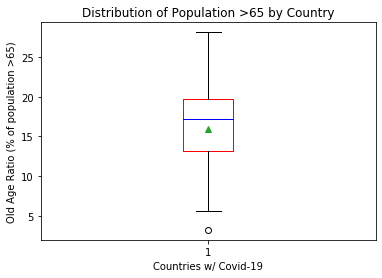

In [95]:
vars=[old_age_ratio_x,mortality_rate_y]

boxplt=plt.boxplot(old_age_ratio_x,showmeans=True)
#print (boxplt.keys())
boxplt['boxes'][0].set_color('r')
#boxplt['boxes'][1].set_color('red')
boxplt['medians'][0].set_color('blue')
#boxplt['medians'][1].set_color('blue')
plt.title('Distribution of Population >65 by Country')
#plt.xticks([1,2],['Running','Cycling'])
plt.xlabel('Countries w/ Covid-19')
plt.ylabel('Old Age Ratio (% of population >65)')
plt.show()

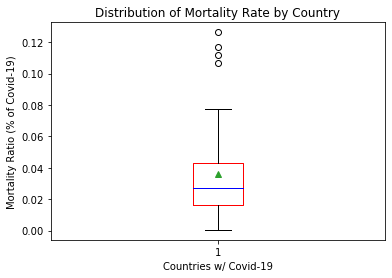

In [96]:
boxplt=plt.boxplot(mortality_rate_y,showmeans=True)
#print (boxplt.keys())
boxplt['boxes'][0].set_color('r')
#boxplt['boxes'][1].set_color('red')
boxplt['medians'][0].set_color('blue')
#boxplt['medians'][1].set_color('blue')
plt.title('Distribution of Mortality Rate by Country')
#plt.xticks([1,2],['Running','Cycling'])
plt.xlabel('Countries w/ Covid-19')
plt.ylabel('Mortality Ratio (% of Covid-19)')
plt.show()